

**Problem Statement:**

Goal: Create a unified hybrid framework that adapts to the commodity type and automatically selects or combines the best models accordingly.

We loaded historical data from 2003-April 2025 alonmg with new realtime data to predict price with pre trained model.

## Step 8 Processing Real Time Data with Pre Trained Models

##### Sourcing Key Libraries


In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np 
import os 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
# from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
#from pmdarima.arima import auto_arima
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor
import os
import itertools
import requests
import yfinance as yf
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
#from arch import arch_model
from transformers import pipeline
#from xgboost import XGBRegressor
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

##### Define constant Variables

In [56]:
# constant values
# Your API Key from FRED
api_key = 'a27b910873da479a5561ea08035a6c79'
# API Key for Alpha Vantage (Replace with your actual key)
API_KEY_alpha = "3J4EGZCB0D7UT9WG"
# genertae your APi key from here: https://www.alphavantage.co/

#update the below code for any new precious Metal

data_ticker_map = {
            'GOLD' : 'GC=F',
            'SILVER': 'SI=F',
            'CRUDE_OIL': 'CL=F'}

data_file_mapping = {
            'GOLD' : '../../Data/Historical_Gold_data_April_2020_2.csv',
           'SILVER': '../../Data/Historical_Silver_data_April.csv',
           'CRUDE_OIL': '../../Data/Historical_Crude_oil_data_April.csv',}

Live_Sentiments_file_name = 'real-Live_Sentiments.csv'
Live_Sentiments_file_dir = '../../Sentiments'
Historical_Sentiments_file_name = 'Historical_Sentiments.csv'
Historical_Sentiments_file_dir = '../../Sentiments'

best_models_dir = {'GOLD': '../../Models/GOLD_MODELS', 'SILVER' : '../../Models/SILVER_MODELS', 'CRUDE_OIL': '../../Models/CRUDE_OIL_MODELS'}
hybrid_models_dir = {'GOLD': '../../Models/GOLD_HYBRID_MODELS', 'SILVER' : '../../Models/SILVER_HYBRID_MODELS', 'CRUDE_OIL': '../../Models/CRUDE_OIL_HYBRID_MODELS'}
hybrid_meta_models_dir = {'GOLD': '../../Models/GOLD_HYBRID_MODELS/Meta', 'SILVER' : '../../Models/SILVER_HYBRID_MODELS/Meta', 'CRUDE_OIL': '../../Models/CRUDE_OIL_HYBRID_MODELS/Meta'}

### Enter Commodity Name for which you want to predict Price EX: GOLD, SILVER, CRUDE OIL etc

In [57]:
commodity = input('Enter the Commodity Name')
filename =  data_file_mapping.get(commodity)
############# Reading Data Sources #################
print(f'Loading from Historical file id Data available in file : {filename}')
ticker = data_ticker_map.get(commodity)
print(f'Ticker code for {commodity} : {ticker}')

Enter the Commodity Name GOLD


Loading from Historical file id Data available in file : ../../Data/Historical_Gold_data_April_2020_2.csv
Ticker code for GOLD : GC=F


In [59]:
d = '30' #input('Enter the number of Days/Hours you eant to predict from real time 30,15,90')
days = int(d)
realtimedays = d+'d'
realtimedays

'30d'

## Data Sourcing

### Historical Data Sourcing

##### Yahoo finance is not reliable and having issues, download data from 2003-01-01 - 2025-03-15 via yf api.

##### Define function to download Historical data 

In [60]:
# Function to download historical price data
def download_price_data(ticker, start='2020-01-01', end='2025-04-28'):
    # Download the data
    data = yf.download(ticker, start=start, end=end)
    
    # Reset index to turn 'Date' into a regular column
    data.reset_index(inplace=True)
    
    # Flatten the columns if there are multiple levels
    data.columns = data.columns.get_level_values(0) if isinstance(data.columns, pd.MultiIndex) else data.columns
    
    # Select necessary columns only
    data = data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
    return data

# Load or download data for each commodity
def load_or_download_data(ticker, filename):
    if os.path.exists(filename):
        # Read the CSV, treating the first row as the header
        # data = pd.read_csv(filename, header=0)
        data = pd.read_csv(filename, header=0)
        # Convert 'Date' column to datetime format, and handle parsing errors
        data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
        
        # Remove any rows where 'Date' could not be parsed and resulted in NaT
        data = data.dropna(subset=['Date'])
    else:
        # Download the data
        data = download_price_data(ticker)
        
        # Save to CSV with a single header row
        data.to_csv(filename, index=False)
    
    # Ensure the 'Close' column is numeric
    data['Close'] = pd.to_numeric(data['Close'], errors='coerce')
    
    return data


In [61]:
############# Reading Data Sources #################
print(f'Loading from Historical file id Data available in file : {filename}')
ticker = data_ticker_map.get(commodity)
print(f'Ticker code for {commodity} : {ticker}')
commodity_data = load_or_download_data(ticker, filename)

Loading from Historical file id Data available in file : ../../Data/Historical_Gold_data_April_2020_2.csv
Ticker code for GOLD : GC=F


### Fetch Realtime Data

In [62]:
# Function to fetch real-time data
def fetch_real_time_data(ticker, period, interval):
    data = yf.download(ticker, period=period, interval=interval)
    data.columns = data.columns.get_level_values(0) if isinstance(data.columns, pd.MultiIndex) else data.columns
    data.columns.name = None
    data.index = pd.to_datetime(data.index).date
    # Select and standardize the required columns
    data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
    return data

###  Realtime Data process

In [63]:

real_time_data = fetch_real_time_data(ticker, period=realtimedays, interval='1h')
# Convert index to Date column
real_time_data['Date'] = real_time_data.index
# Reset index
real_time_data.reset_index(drop=True, inplace=True)
# Ensure 'Date' is datetime without timezone
real_time_data['Date'] = pd.to_datetime(real_time_data['Date']).dt.normalize()
# Reorder columns
real_time_data = real_time_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

# Print output
print(real_time_data.head())
# ######## Combine Real TIme data with Historical data
commodity_data = real_time_data


[*********************100%***********************]  1 of 1 completed

        Date         Open         High          Low        Close  Volume
0 2025-03-28  3084.899902  3085.500000  3082.399902  3083.100098       0
1 2025-03-28  3083.699951  3090.000000  3082.500000  3087.500000     299
2 2025-03-28  3086.100098  3093.500000  3086.000000  3092.800049     667
3 2025-03-28  3091.800049  3122.300049  3088.399902  3118.000000   41559
4 2025-03-28  3117.899902  3120.300049  3078.000000  3113.199951   11593


In [64]:
real_time_data

,Date,Open,High,Low,Close,Volume
0,2025-03-28,3084.899902,3085.500000,3082.399902,3083.100098,0
1,2025-03-28,3083.699951,3090.000000,3082.500000,3087.500000,299
2,2025-03-28,3086.100098,3093.500000,3086.000000,3092.800049,667
3,2025-03-28,3091.800049,3122.300049,3088.399902,3118.000000,41559
4,2025-03-28,3117.899902,3120.300049,3078.000000,3113.199951,11593
...,...,...,...,...,...,...
564,2025-05-02,3240.000000,3243.800049,3229.500000,3232.000000,17575
565,2025-05-02,3231.800049,3247.399902,3230.300049,3238.399902,12735
566,2025-05-02,3238.600098,3240.000000,3231.699951,3234.199951,4695
567,2025-05-02,3234.199951,3242.300049,3234.199951,3241.399902,5787


### Sourcing Market data

####  GDP data

##### Define function which will convert Yearly GDP data to daily GDP data

In [65]:
def expand_gdp_to_daily(gdp_df):
    daily_gdp = []
    for index, row in gdp_df.iterrows():
        month_start = row['Date']
        value = row['Value']
        month_days = pd.date_range(start=month_start, end=month_start + pd.offsets.MonthEnd(0), freq='D')
        for day in month_days:
            daily_gdp.append({'Date': day, 'Value': value})
    return pd.DataFrame(daily_gdp)


def preprocess_gdp_data(gdp_data):
    gdp_data['Date'] = pd.to_datetime(gdp_data['Date'])
    return expand_gdp_to_daily(gdp_data)


def fetch_world_bank_data(indicator, country='USA', start_year='2003', end_year='2025'):
    url = f'http://api.worldbank.org/v2/country/{country}/indicator/{indicator}?date={start_year}:{end_year}&format=json'
    try:
        response = requests.get(url)
        data = response.json()
        if len(data) < 2 or 'message' in data[1]:
            print("No data found for the specified parameters.")
            return None
        df = pd.json_normalize(data[1])
        df['date'] = pd.to_datetime(df['date'])
        df = df[(df['date'] >= f'{start_year}-01-01') & (df['date'] <= f'{end_year}-12-31')]
        df = df[['date', 'value']]
        df.columns = ['Date', 'Value']
        return df
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None


In [66]:
############### sourcing world GDP data #################################################
gdp_data = fetch_world_bank_data('NY.GDP.MKTP.CD', country='USA', start_year='2003', end_year='2024')
daily_gdp_data = preprocess_gdp_data(gdp_data)
daily_gdp_data.rename(columns={'Value':'GDP'},inplace=True)
daily_gdp_data

,Date,GDP
0,2024-01-01,NaT
1,2024-01-02,NaT
2,2024-01-03,NaT
3,2024-01-04,NaT
4,2024-01-05,NaT
...,...,...
677,2003-01-27,11456450000000.0
678,2003-01-28,11456450000000.0
679,2003-01-29,11456450000000.0
680,2003-01-30,11456450000000.0


####  Interest rate data

In [67]:

############## Sourcing Interest rate data ################################
from fredapi import Fred

# Your API Key from FRED
api_key = 'a27b910873da479a5561ea08035a6c79'

# Initialize the FRED API
fred = Fred(api_key=api_key)

# Fetch the Federal Funds Rate data (you can change this to any other indicator)
# Federal Funds Rate is often identified by the FRED ID 'FEDFUNDS'
interest_rate_data = fred.get_series('FEDFUNDS' ,start_date='2003-01-01')

# Convert the data into a DataFrame for better handling
interest_rate_df = pd.DataFrame(interest_rate_data)
interest_rate_df.columns = ['Interest_rates']

# Reset the index to have 'Date' as a column
interest_rate_df.reset_index(inplace=True)

import pandas as pd

# Assuming `interest_rate_df` already exists with 'Date' and 'Interest_rates' columns

# Convert 'Date' column to datetime format if it’s not already
interest_rate_df['Date'] = pd.to_datetime(interest_rate_df['index'])
interest_rate_df.drop(columns=['index'], inplace=True)  # Drop the old index column if needed

# Create a date range for every day from the start to the end of the interest rate data
start_date = interest_rate_df['Date'].min()
end_date = interest_rate_df['Date'].max()
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Create a new DataFrame with daily dates as a column
daily_interest_rate_df = pd.DataFrame({'date': date_range})

# Add a 'month' and 'year' column to `interest_rate_df` for easy merging
interest_rate_df['year'] = interest_rate_df['Date'].dt.year
interest_rate_df['month'] = interest_rate_df['Date'].dt.month

# Merge monthly data with daily data on matching 'year' and 'month'
daily_interest_rate_df['year'] = daily_interest_rate_df['date'].dt.year
daily_interest_rate_df['month'] = daily_interest_rate_df['date'].dt.month

# Perform a left join on 'year' and 'month' columns
daily_interest_rate_df = daily_interest_rate_df.merge(
    interest_rate_df[['year', 'month', 'Interest_rates']],
    on=['year', 'month'],
    how='left'
)

# Drop the extra columns, keep only 'date' and 'Interest_rates'
daily_interest_rate_data = daily_interest_rate_df[['date', 'Interest_rates']]
daily_interest_rate_data.rename(columns={'date':'Date'},inplace=True)
daily_interest_rate_data


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3972\1493415932.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_interest_rate_data.rename(columns={'date':'Date'},inplace=True)


,Date,Interest_rates
0,1954-07-01,0.80
1,1954-07-02,0.80
2,1954-07-03,0.80
3,1954-07-04,0.80
4,1954-07-05,0.80
...,...,...
25838,2025-03-28,4.33
25839,2025-03-29,4.33
25840,2025-03-30,4.33
25841,2025-03-31,4.33


####  GDP to Debt data

In [68]:
################## GDP to Debt DATA ###############################
import wbdata
import pandas as pd
import datetime

# Set the start and end dates for the data
start_date = datetime.datetime(2000, 1, 1)
end_date = datetime.datetime(2023, 1, 1)

# List of indicators to retrieve (Government Debt to GDP ratio)
indicators = {'GC.DOD.TOTL.GD.ZS': 'Government Debt to GDP'}

# Fetch data from the World Bank API for the USA
government_debt_data = wbdata.get_dataframe(indicators, country='USA')

# Fill missing values in `Government Debt to GDP` with 0
government_debt_data['Government Debt to GDP'] = government_debt_data['Government Debt to GDP'].fillna(0)

# Reset index to make `date` a regular column and convert it to datetime
government_debt_data.reset_index(inplace=True)
government_debt_data['date'] = pd.to_datetime(government_debt_data['date'])

# Add a 'year' column to `government_debt_data` to help with mapping
government_debt_data['year'] = government_debt_data['date'].dt.year

# Create a dictionary for quick lookup of Debt to GDP per year
debt_to_gdp_dict = government_debt_data.set_index('year')['Government Debt to GDP'].to_dict()

# Create a date range for every day from the start to the end date
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Create a new DataFrame with daily dates as a column
daily_debt_data = pd.DataFrame({'date': date_range})

# Map each date in `daily_debt_data` to the corresponding Debt to GDP value for that year
daily_debt_data['DebtToGDP'] = daily_debt_data['date'].dt.year.map(debt_to_gdp_dict)
daily_debt_data.rename(columns={'date':'Date'},inplace=True)

daily_debt_data

,Date,DebtToGDP
0,2000-01-01,33.267642
1,2000-01-02,33.267642
2,2000-01-03,33.267642
3,2000-01-04,33.267642
4,2000-01-05,33.267642
...,...,...
8397,2022-12-28,110.385332
8398,2022-12-29,110.385332
8399,2022-12-30,110.385332
8400,2022-12-31,110.385332


####  Inflation data

In [69]:
############## inflation data #################
# Get historical CPI data (Consumer Price Index) to calculate inflation
cpi_data = fred.get_series('CPIAUCSL', start_date='2003-01-01')



# Convert the data into a DataFrame for better handling
Inflation_data = pd.DataFrame(interest_rate_data)
Inflation_data.columns = ['Inflation_rate']

# Reset the index to have 'Date' as a column
Inflation_data.reset_index(inplace=True)
Inflation_data.rename(columns={'index':'Date'},inplace=True)
# Print the first few rows
Inflation_data

,Date,Inflation_rate
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83
...,...,...
845,2024-12-01,4.48
846,2025-01-01,4.33
847,2025-02-01,4.33
848,2025-03-01,4.33


####  ETF data

In [70]:
################ Gold ETF data ###########################################
import requests
import pandas as pd

# Fetch ETF data from FRED API
def fetch_fred_etf_data(series_id, api_key, start_date='2003-01-01', end_date='2024-11-01'):
    url = f'https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type=json&observation_start={start_date}&observation_end={end_date}'
    response = requests.get(url)
    data = response.json()
    
    # Print the entire JSON response for inspection
    print("Full JSON response:", data)
    
    # Check for errors in the JSON response
    if "observations" not in data:
        print("Error: 'observations' key not found in the response. Check the series ID or API request.")
        return None
    
    # Parse JSON data into a DataFrame
    etf_df = pd.DataFrame(data['observations'])
    etf_df['Date'] = pd.to_datetime(etf_df['date'])
    etf_df['Date'] = etf_df['Date'].dt.tz_localize(None).dt.date 
    etf_df['value'] = pd.to_numeric(etf_df['value'], errors='coerce')
    etf_df.set_index('Date', inplace=True)
    
    return etf_df

# Example usage
api_key = 'a27b910873da479a5561ea08035a6c79'
series_id = 'INTDSRUSM193N'  # Replace with a valid series ID from FRED
etf_data = fetch_fred_etf_data(series_id, api_key)


etf_data.rename(columns={'value':'ETF_Value'},inplace=True)
# Only print if data retrieval was successful
if etf_data is not None:
    print(etf_data.head())

Full JSON response: {'realtime_start': '2025-04-18', 'realtime_end': '2025-04-18', 'observation_start': '2003-01-01', 'observation_end': '2024-11-01', 'units': 'lin', 'output_type': 1, 'file_type': 'json', 'order_by': 'observation_date', 'sort_order': 'asc', 'count': 224, 'offset': 0, 'limit': 100000, 'observations': [{'realtime_start': '2025-04-18', 'realtime_end': '2025-04-18', 'date': '2003-01-01', 'value': '2.25'}, {'realtime_start': '2025-04-18', 'realtime_end': '2025-04-18', 'date': '2003-02-01', 'value': '2.25'}, {'realtime_start': '2025-04-18', 'realtime_end': '2025-04-18', 'date': '2003-03-01', 'value': '2.25'}, {'realtime_start': '2025-04-18', 'realtime_end': '2025-04-18', 'date': '2003-04-01', 'value': '2.25'}, {'realtime_start': '2025-04-18', 'realtime_end': '2025-04-18', 'date': '2003-05-01', 'value': '2.25'}, {'realtime_start': '2025-04-18', 'realtime_end': '2025-04-18', 'date': '2003-06-01', 'value': '2'}, {'realtime_start': '2025-04-18', 'realtime_end': '2025-04-18', 'd

## Sourcing Sentiment Data and Apply BERT

#### Sourcing Live Sentiments

In [71]:
import requests
import pandas as pd
from transformers import pipeline
from datetime import datetime, timedelta

# Set up NewsAPI
API_KEY = "250e051931514de6b0e5120412c4e3ad"
NEWS_API_URL = "https://newsapi.org/v2/everything"

# Fetch news using query
def fetch_news(query, language="en", page_size=100):
    params = {
        "q": query,
        "language": language,
        "apiKey": API_KEY,
        "pageSize": page_size,
        "sortBy": "publishedAt",
    }
    response = requests.get(NEWS_API_URL, params=params)
    data = response.json()
    
    if data.get("status") == "ok":
        articles = data.get("articles", [])
        return [(article["publishedAt"], article["title"]) for article in articles]
    else:
        print("Error fetching news:", data)
        return []

# Load FinBERT pipeline
sentiment_pipeline = pipeline("text-classification", model="ProsusAI/finbert")

def analyze_sentiment(texts):
    sentiments = sentiment_pipeline(texts, truncation=True)
    return [sent["label"] for sent in sentiments]

# Combined sentiment fetcher for crude oil-related queries
def get_gold_sentiment():
    queries =  [
    "gold price",
    "gold futures",
    "gold market",
    "gold trading",
    "gold commodity",
    "gold ETF",
    "precious metals",
    "gold demand",
    "gold mining"
]
    all_articles = []

    for query in queries:
        articles = fetch_news(query)
        all_articles.extend(articles)

    if not all_articles:
        return pd.DataFrame()

    df = pd.DataFrame(all_articles, columns=["Date", "Headline"])
    df["Sentiment"] = analyze_sentiment(df["Headline"].tolist())
    df.to_csv("gold_sentiment_data.csv", index=False)
    return df


#### Apply Sentiment analysis on Live data and save them in disk

In [72]:
# Save the new data
import os
Live_Sentiments_file = os.path.join(Live_Sentiments_file_dir, commodity.upper(), Live_Sentiments_file_name)
if os.path.exists(Live_Sentiments_file):
    # sentiment_df = get_gold_sentiment()
    # sentiment_df.to_csv(Live_Sentiments_file, index=False)
    sentiment_df =  pd.read_csv(Live_Sentiments_file)  # File does not exist
else:
    # Fetch sentiment data
    sentiment_df = get_gold_sentiment()
    sentiment_df.to_csv(Live_Sentiments_file, index=False)
print(sentiment_df.head())
sentiment_df['Sentiment_score'] = sentiment_df['Sentiment'].apply(lambda x: 1 if x == 'positive' else -1 if x == 'negative' else 0)
print(sentiment_df.head())

# Add sentiment data back to the news_df
sentiment_df[['Date', 'Headline', 'Sentiment', 'Sentiment_score']]
live_sentiments_df = sentiment_df[['Date', 'Headline', 'Sentiment', 'Sentiment_score']]
# # Print out the resulting dataframe
# print(news_df[['Date', 'Title', 'Sentiment']].head())

# Convert Date column to datetime and add a range of days around each event
live_sentiments_df['Date'] = pd.to_datetime(live_sentiments_df['Date'])



live_sentiments_df['Date'] = pd.to_datetime(live_sentiments_df['Date'], errors='coerce')
live_sentiments_df['Date'] = live_sentiments_df['Date'].dt.tz_localize(None).dt.date 
live_sentiments_df.head()

                   Date                                           Headline  \
0  2025-05-01T16:22:23Z  Whatever happens with Trump’s tariffs, investo...   
1  2025-05-01T16:19:25Z  Iconic Portrait of Buzz Aldrin on the Moon Sel...   
2  2025-05-01T16:15:51Z                         Today’s News in a Nutshell   
3  2025-05-01T16:06:08Z  $80 Switch 2 and now Xbox games aren't a big s...   
4  2025-05-01T16:02:00Z  Norm Macdonald’s ‘Dirty Work’ Gets Even Dirtie...   

  Sentiment  
0   neutral  
1   neutral  
2   neutral  
3   neutral  
4  negative  
                   Date                                           Headline  \
0  2025-05-01T16:22:23Z  Whatever happens with Trump’s tariffs, investo...   
1  2025-05-01T16:19:25Z  Iconic Portrait of Buzz Aldrin on the Moon Sel...   
2  2025-05-01T16:15:51Z                         Today’s News in a Nutshell   
3  2025-05-01T16:06:08Z  $80 Switch 2 and now Xbox games aren't a big s...   
4  2025-05-01T16:02:00Z  Norm Macdonald’s ‘Dirty Work’ Ge

,Date,Headline,Sentiment,Sentiment_score
0,2025-05-01,"Whatever happens with Trump’s tariffs, investo...",neutral,0
1,2025-05-01,Iconic Portrait of Buzz Aldrin on the Moon Sel...,neutral,0
2,2025-05-01,Today’s News in a Nutshell,neutral,0
3,2025-05-01,$80 Switch 2 and now Xbox games aren't a big s...,neutral,0
4,2025-05-01,Norm Macdonald’s ‘Dirty Work’ Gets Even Dirtie...,negative,-1


#### Load Historical Sentiment data

In [73]:
Historical_Sentiments_file = os.path.join(Historical_Sentiments_file_dir, commodity.upper(), Historical_Sentiments_file_name)
#Detect Invalid Dates
def is_invalid_date(date_str):
    try:
        pd.to_datetime(date_str, format="%d-%m-%Y", errors="raise")
        return False  # Valid date
    except:
        return True   # Invalid date



if os.path.exists(Historical_Sentiments_file) and commodity.upper()=="GOLD":
        historical_news_df =  pd.read_csv(Historical_Sentiments_file)  # File does not exist
        print(historical_news_df)
elif commodity.upper()=="GOLD" :
    # Fetch sentiment data
    historical_sentiment_data = pd.read_csv("C:/Users/Lenovo/OneDrive/Desktop/War/code/data/gold_historical_sentiments.csv", usecols=["Dates","Price Sentiment", "News"])
    historical_sentiment_data = historical_sentiment_data[~historical_sentiment_data["Dates"].astype(str).apply(is_invalid_date)]
    
    
    # Add sentiment data back to the news_df
    # # Print out the resulting dataframe
    # print(news_df[['Date', 'Title', 'Sentiment']].head())
    historical_news_df = historical_sentiment_data[['Dates', 'News', 'Price Sentiment', 'Sentiment_score']]
    historical_news_df.rename(columns = {'News':'Headline', 'Dates':'Date', 'Price Sentiment':'Sentiment'}, inplace = True)
    
    # Convert Date column to datetime and add a range of days around each event
    historical_news_df['Date'] = pd.to_datetime(historical_news_df['Date'])
    historical_news_df['Date'] = pd.to_datetime(historical_news_df['Date'], errors='coerce')
    historical_news_df['Date'] = historical_news_df['Date'].dt.tz_localize(None).dt.date 

    historical_news_df = historical_news_df[['Date','Headline']]
    historical_news_df["Sentiment_score"] = analyze_sentiment(historical_news_df["Headline"].tolist(), batch_size=16)
    historical_news_df['Sentiment_score'] = historical_news_df['Sentiment_score'].apply(lambda x: 1 if x == 'positive' else -1 if x == 'negative' else 0)
    historical_news_df.to_csv(Historical_Sentiments_file, index=False)
else:
    historical_news_df=live_sentiments_df




             Date                                           Headline  \
0      2016-01-28  april gold down 20 cents to settle at $1,116.1...   
1      2017-09-13          gold suffers third straight daily decline   
2      2016-07-26     Gold futures edge up after two-session decline   
3      2018-02-28  dent research : is gold's day in the sun comin...   
4      2017-09-06  Gold snaps three-day rally as Trump, lawmakers...   
...           ...                                                ...   
10400  2013-01-07       gold seen falling from 3-week high this week   
10401  2018-09-27  dominic frisby : now looks like a good time to...   
10402  2017-03-03  Gold heading for worst week since November on ...   
10403  2008-06-11  august gold up $7.60 at $878.80 an ounce on nymex   
10404  2007-10-01    december gold down $1 at $749 an ounce on nymex   

      BERT_Sentiment  Sentiment_score  
0           negative               -1  
1           negative               -1  
2           pos

## Step 2 : Data Preprocessing and Cleaning

### 2.1 Null Value Treatment

In [74]:
for data in [commodity_data]:
    data.dropna(subset=['Date', 'Close'], inplace=True)

### 2.2 Converting Values to Datetime format

In [75]:
# COnvert into date format
# Historical Data
# Convert Date column in gold_data to remove timezone
commodity_data['Date'] = commodity_data['Date'].dt.tz_localize(None).dt.date 

# Market Economic Data
daily_gdp_data['Date'] = daily_gdp_data['Date'].dt.tz_localize(None).dt.date 
interest_rate_df['Date'] = interest_rate_df['Date'].dt.tz_localize(None).dt.date 
Inflation_data['Date'] = Inflation_data['Date'].dt.tz_localize(None).dt.date 
daily_debt_data['Date'] = daily_debt_data['Date'].dt.tz_localize(None).dt.date 

### 2.3 Merging all source data to final data frame

In [76]:
# Merge all dataframes on 'Date' with 'gold_data' as the base (left join)
merged_data = commodity_data.merge(daily_gdp_data, on='Date', how='left') \
                       .merge(interest_rate_df, on='Date', how='left') \
                       .merge(Inflation_data, on='Date', how='left') \
                       .merge(daily_debt_data, on='Date', how='left') \
                        .merge(etf_data[['ETF_Value']], on='Date', how='left')

merged_data.drop(columns=['year','month'],inplace=True)

In [77]:
merged_data.info()
# Print summary of missing values after imputation
print(merged_data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            569 non-null    object 
 1   Open            569 non-null    float64
 2   High            569 non-null    float64
 3   Low             569 non-null    float64
 4   Close           569 non-null    float64
 5   Volume          569 non-null    int64  
 6   GDP             0 non-null      object 
 7   Interest_rates  23 non-null     float64
 8   Inflation_rate  23 non-null     float64
 9   DebtToGDP       0 non-null      float64
 10  ETF_Value       0 non-null      float64
dtypes: float64(8), int64(1), object(2)
memory usage: 49.0+ KB
Date                0
Open                0
High                0
Low                 0
Close               0
Volume              0
GDP               569
Interest_rates    546
Inflation_rate    546
DebtToGDP         569
ETF_Value         569
dtype

### 2.4 Processing NULL values from merged data

In [78]:

# Convert numeric columns from object type to float (if needed)
numeric_cols = ["Open", "High", "Low", "Close", "Volume"]
merged_data[numeric_cols] = merged_data[numeric_cols].apply(pd.to_numeric, errors="coerce")

# Handle Financial Market Data (Time-series features)
merged_data[numeric_cols] = merged_data[numeric_cols].fillna(method="ffill")  # Forward Fill (Recommended)

#  Handle Volume (Typically Skewed, Use Median)
merged_data["Volume"].fillna(merged_data["Volume"].median(), inplace=True)

# 🔹 Handle Economic Indicators (Use Mean or Interpolation)
econ_cols = ["GDP", "DebtToGDP", "Interest_rates", "Inflation_rate", "ETF_Value"]
for col in econ_cols:
    merged_data[col].fillna(merged_data[col].mean(), inplace=True)  # Mean Imputation
    merged_data[col].fillna(0, inplace=True)  # Mean Imputation


# Print summary of missing values after imputation
print(merged_data.isnull().sum())

commodity_data=merged_data

Date              0
Open              0
High              0
Low               0
Close             0
Volume            0
GDP               0
Interest_rates    0
Inflation_rate    0
DebtToGDP         0
ETF_Value         0
dtype: int64


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3972\3625551758.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data[numeric_cols] = merged_data[numeric_cols].fillna(method="ffill")  # Forward Fill (Recommended)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3972\3625551758.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data["Volume"].fillna(merged_data["Volume"].median(), inplace=True)
C:\Users\Lenovo\AppData\Local\Te

### Outlier Treatment

In [79]:

# Function to identify and remove outliers using IQR
def identify_outliers(df):
    # Ensure 'Close' is numeric
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')  # Convert to float, set errors to NaN
    df = df.dropna(subset=['Close'])  # Drop rows where 'Close' is NaN after conversion

    Q1 = df['Close'].quantile(0.25)
    Q3 = df['Close'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    ndf = df[(df['Close'] <= lower_bound) | (df['Close'] >= upper_bound)]
    return ndf

# Apply outlier detection to the Gold dataset
commodity_data['Close'] = pd.to_numeric(commodity_data['Close'], errors='coerce')  # Ensure 'Close' is numeric
outlier = identify_outliers(commodity_data)
outlier

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value


In [80]:
commodity_data

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value
0,2025-03-28,3084.899902,3085.500000,3082.399902,3083.100098,0,0.0,4.33,4.33,0.0,0.0
1,2025-03-28,3083.699951,3090.000000,3082.500000,3087.500000,299,0.0,4.33,4.33,0.0,0.0
2,2025-03-28,3086.100098,3093.500000,3086.000000,3092.800049,667,0.0,4.33,4.33,0.0,0.0
3,2025-03-28,3091.800049,3122.300049,3088.399902,3118.000000,41559,0.0,4.33,4.33,0.0,0.0
4,2025-03-28,3117.899902,3120.300049,3078.000000,3113.199951,11593,0.0,4.33,4.33,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
564,2025-05-02,3240.000000,3243.800049,3229.500000,3232.000000,17575,0.0,4.33,4.33,0.0,0.0
565,2025-05-02,3231.800049,3247.399902,3230.300049,3238.399902,12735,0.0,4.33,4.33,0.0,0.0
566,2025-05-02,3238.600098,3240.000000,3231.699951,3234.199951,4695,0.0,4.33,4.33,0.0,0.0
567,2025-05-02,3234.199951,3242.300049,3234.199951,3241.399902,5787,0.0,4.33,4.33,0.0,0.0


###  Data Merging - Sentiments with Commodity Data

#### Merging Live and Histrical Sentiment data

In [81]:
live_sentiments_df = live_sentiments_df[['Date','Sentiment_score']]
historical_news_df = historical_news_df[['Date','Sentiment_score']]

In [82]:
# Convert 'Date' column to datetime format in both DataFrames
live_sentiments_df['Date'] = pd.to_datetime(live_sentiments_df['Date'])
historical_news_df['Date'] = pd.to_datetime(historical_news_df['Date'])

# Merge the DataFrames and sort by 'Date'
sentiment_df = pd.concat([live_sentiments_df, historical_news_df], ignore_index=True).sort_values(by='Date')

# Display the first few rows
print(sentiment_df.head())


            Date  Sentiment_score
5122  2000-02-15                0
10468 2000-02-17               -1
2759  2000-03-24               -1
3068  2000-04-27                1
9488  2000-05-04               -1


In [83]:
commodity_data['Date'] = pd.to_datetime(commodity_data['Date'])

In [84]:
commodity_data.tail()

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value
564,2025-05-02,3240.000000,3243.800049,3229.500000,3232.000000,17575,0.0,4.33,4.33,0.0,0.0
565,2025-05-02,3231.800049,3247.399902,3230.300049,3238.399902,12735,0.0,4.33,4.33,0.0,0.0
566,2025-05-02,3238.600098,3240.000000,3231.699951,3234.199951,4695,0.0,4.33,4.33,0.0,0.0
567,2025-05-02,3234.199951,3242.300049,3234.199951,3241.399902,5787,0.0,4.33,4.33,0.0,0.0
568,2025-05-02,3241.500000,3249.199951,3240.500000,3247.399902,4215,0.0,4.33,4.33,0.0,0.0


### 2.8 Merging Sentiment Data with Gold Data

In [85]:
commodity_data = pd.merge(commodity_data, sentiment_df[['Date', 'Sentiment_score']], on='Date', how='left')
commodity_data.head()

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value,Sentiment_score
0,2025-03-28,3084.899902,3085.500000,3082.399902,3083.100098,0,0.0,4.33,4.33,0.0,0.0,NaN
1,2025-03-28,3083.699951,3090.000000,3082.500000,3087.500000,299,0.0,4.33,4.33,0.0,0.0,NaN
2,2025-03-28,3086.100098,3093.500000,3086.000000,3092.800049,667,0.0,4.33,4.33,0.0,0.0,NaN
3,2025-03-28,3091.800049,3122.300049,3088.399902,3118.000000,41559,0.0,4.33,4.33,0.0,0.0,NaN
4,2025-03-28,3117.899902,3120.300049,3078.000000,3113.199951,11593,0.0,4.33,4.33,0.0,0.0,NaN


In [86]:
commodity_data['Sentiment_score'].value_counts()

Sentiment_score
 0.0    12084
-1.0     3699
 1.0     3637
Name: count, dtype: int64

### 2.9 Null Treatment post sentiment merge

In [87]:
#Interpolation – Estimate Sentiment Values Based on Nearby Data
#Good for gradual sentiment changes but may not capture sudden shifts.
commodity_data['Sentiment_score'] = sentiment_df['Sentiment_score'].interpolate(method='linear')  

commodity_data['Sentiment_score'].fillna(0, inplace=True)
# Print summary of missing values after imputation
print(commodity_data.isnull().sum())

Date               0
Open               0
High               0
Low                0
Close              0
Volume             0
GDP                0
Interest_rates     0
Inflation_rate     0
DebtToGDP          0
ETF_Value          0
Sentiment_score    0
dtype: int64


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3972\1915627315.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  commodity_data['Sentiment_score'].fillna(0, inplace=True)


In [88]:
commodity_data['Sentiment_score'].value_counts()

Sentiment_score
 0.0    10852
-1.0     4665
 1.0     4357
Name: count, dtype: int64

In [89]:
commodity_data

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value,Sentiment_score
0,2025-03-28,3084.899902,3085.500000,3082.399902,3083.100098,0,0.0,4.33,4.33,0.0,0.0,0.0
1,2025-03-28,3083.699951,3090.000000,3082.500000,3087.500000,299,0.0,4.33,4.33,0.0,0.0,0.0
2,2025-03-28,3086.100098,3093.500000,3086.000000,3092.800049,667,0.0,4.33,4.33,0.0,0.0,0.0
3,2025-03-28,3091.800049,3122.300049,3088.399902,3118.000000,41559,0.0,4.33,4.33,0.0,0.0,0.0
4,2025-03-28,3117.899902,3120.300049,3078.000000,3113.199951,11593,0.0,4.33,4.33,0.0,0.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
19869,2025-05-02,3240.000000,3243.800049,3229.500000,3232.000000,17575,0.0,4.33,4.33,0.0,0.0,0.0
19870,2025-05-02,3231.800049,3247.399902,3230.300049,3238.399902,12735,0.0,4.33,4.33,0.0,0.0,0.0
19871,2025-05-02,3238.600098,3240.000000,3231.699951,3234.199951,4695,0.0,4.33,4.33,0.0,0.0,0.0
19872,2025-05-02,3234.199951,3242.300049,3234.199951,3241.399902,5787,0.0,4.33,4.33,0.0,0.0,0.0


## Step 3 : Feature Engineering

### 4.1 Create Features 

In [90]:
import numpy as np

def feature_engineering(df, world_bank_data=None):
    # Lagged values and moving averages
    df['lag_1'] = df['Close'].shift(1)
    df['lag_7'] = df['Close'].shift(7)
    df['lag_30'] = df['Close'].shift(30)
    df['MA_7'] = df['Close'].rolling(window=7).mean()
    df['MA_30'] = df['Close'].rolling(window=30).mean()
    df['MA_90'] = df['Close'].rolling(window=90).mean()
    # Compute log returns fro GARCH
    df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))

    # Adding volatility features
    df['volatility_7'] = df['Close'].rolling(window=7).std()
    df['volatility_30'] = df['Close'].rolling(window=30).std()

    # #Gold prices may respond more to cumulative sentiment trends rather than individual daily sentiments. We apply a moving average to smooth fluctuations.
    # # Creating lagged sentiment features
    # df["Sentiment_Lag_1"] = df["Sentiment_score"].shift(1)
    # df["Sentiment_Lag_3"] = df["Sentiment_score"].shift(3)
    # df["Sentiment_Lag_7"] = df["Sentiment_score"].shift(7)
    # Compute rolling mean sentiment over 14-day and 30-day windows
    df["Sentiment_Rolling_14"] = df["Sentiment_score"].rolling(window=14, min_periods=1).mean()
    df["Sentiment_Rolling_30"] = df["Sentiment_score"].rolling(window=30, min_periods=1).mean()

    return df


### 4.2 Apply Feature engineering on data

In [91]:
commodity_data = feature_engineering(commodity_data)

In [92]:
feature_engineering(commodity_data)

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,...,lag_30,MA_7,MA_30,MA_90,tomorrow_price,Log_Returns,volatility_7,volatility_30,Sentiment_Rolling_14,Sentiment_Rolling_30
0,2025-03-28,3084.899902,3085.500000,3082.399902,3083.100098,0,0.0,4.33,4.33,0.0,...,NaN,NaN,NaN,NaN,3087.500000,NaN,NaN,NaN,0.0,0.0
1,2025-03-28,3083.699951,3090.000000,3082.500000,3087.500000,299,0.0,4.33,4.33,0.0,...,NaN,NaN,NaN,NaN,3092.800049,0.001426,NaN,NaN,0.0,0.0
2,2025-03-28,3086.100098,3093.500000,3086.000000,3092.800049,667,0.0,4.33,4.33,0.0,...,NaN,NaN,NaN,NaN,3118.000000,0.001715,NaN,NaN,0.0,0.0
3,2025-03-28,3091.800049,3122.300049,3088.399902,3118.000000,41559,0.0,4.33,4.33,0.0,...,NaN,NaN,NaN,NaN,3113.199951,0.008115,NaN,NaN,0.0,0.0
4,2025-03-28,3117.899902,3120.300049,3078.000000,3113.199951,11593,0.0,4.33,4.33,0.0,...,NaN,NaN,NaN,NaN,3110.899902,-0.001541,NaN,NaN,-0.2,-0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19869,2025-05-02,3240.000000,3243.800049,3229.500000,3232.000000,17575,0.0,4.33,4.33,0.0,...,3246.199951,3256.614293,3253.053304,3248.484402,3238.399902,-0.002410,15.319185,11.000935,0.0,0.0
19870,2025-05-02,3231.800049,3247.399902,3230.300049,3238.399902,12735,0.0,4.33,4.33,0.0,...,3246.199951,3252.457136,3252.793302,3248.397735,3234.199951,0.001978,15.813266,11.257675,0.0,0.0
19871,2025-05-02,3238.600098,3240.000000,3231.699951,3234.199951,4695,0.0,4.33,4.33,0.0,...,3246.199951,3247.357143,3252.393302,3248.264402,3241.399902,-0.001298,14.985334,11.704350,0.0,0.0
19872,2025-05-02,3234.199951,3242.300049,3234.199951,3241.399902,5787,0.0,4.33,4.33,0.0,...,3246.199951,3245.042829,3252.233301,3248.211068,3247.399902,0.002224,14.378454,11.824131,0.0,0.0


In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation of all features with 'Close'
correlation_with_close = commodity_data.corr()["Close"].sort_values(ascending=False)

# Convert to DataFrame
correlation_df = correlation_with_close.to_frame().rename(columns={"Close": "Correlation"})

correlation_df


,Correlation
Close,1.000000
tomorrow_price,0.999147
lag_1,0.999147
MA_7,0.998609
lag_7,0.994663
MA_30,0.990752
Low,0.990580
High,0.990183
Open,0.976522
lag_30,0.968201


### 4.3 Seting Index of data frame is as a Date column

In [94]:
commodity_data_df = commodity_data
# commodity_data_df = commodity_data_df.drop_duplicates(subset='Date', keep='first')
commodity_data_df.set_index('Date', drop=True, inplace=True)
commodity_data_df = commodity_data_df.fillna(0.0)

In [95]:
commodity_data_df

,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value,...,lag_30,MA_7,MA_30,MA_90,tomorrow_price,Log_Returns,volatility_7,volatility_30,Sentiment_Rolling_14,Sentiment_Rolling_30
Date,,,,,,,,,,,,,,,,,,,,,
2025-03-28,3084.899902,3085.500000,3082.399902,3083.100098,0,0.0,4.33,4.33,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,3087.500000,0.000000,0.000000,0.000000,0.0,0.0
2025-03-28,3083.699951,3090.000000,3082.500000,3087.500000,299,0.0,4.33,4.33,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,3092.800049,0.001426,0.000000,0.000000,0.0,0.0
2025-03-28,3086.100098,3093.500000,3086.000000,3092.800049,667,0.0,4.33,4.33,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,3118.000000,0.001715,0.000000,0.000000,0.0,0.0
2025-03-28,3091.800049,3122.300049,3088.399902,3118.000000,41559,0.0,4.33,4.33,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,3113.199951,0.008115,0.000000,0.000000,0.0,0.0
2025-03-28,3117.899902,3120.300049,3078.000000,3113.199951,11593,0.0,4.33,4.33,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,3110.899902,-0.001541,0.000000,0.000000,-0.2,-0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-02,3240.000000,3243.800049,3229.500000,3232.000000,17575,0.0,4.33,4.33,0.0,0.0,...,3246.199951,3256.614293,3253.053304,3248.484402,3238.399902,-0.002410,15.319185,11.000935,0.0,0.0
2025-05-02,3231.800049,3247.399902,3230.300049,3238.399902,12735,0.0,4.33,4.33,0.0,0.0,...,3246.199951,3252.457136,3252.793302,3248.397735,3234.199951,0.001978,15.813266,11.257675,0.0,0.0
2025-05-02,3238.600098,3240.000000,3231.699951,3234.199951,4695,0.0,4.33,4.33,0.0,0.0,...,3246.199951,3247.357143,3252.393302,3248.264402,3241.399902,-0.001298,14.985334,11.704350,0.0,0.0


### Step 5 Data Split and Scaling

In [96]:
import pandas as pd


# Convert index to datetime if not already
commodity_data_df.index = pd.to_datetime(commodity_data_df.index)

# Define 80-20% split based on row count
split_index = int(len(commodity_data_df) * 0.80) 
# split_date =  pd.to_datetime('2022-01-01')
split_date = commodity_data_df.index[split_index]  

# Train-test split
train_df = commodity_data_df.loc[:split_date]  
test_df = commodity_data_df.loc[split_date:]

print(f"Train size: {train_df.shape}, Test size: {test_df.shape}")


Train size: (19853, 23), Test size: (8646, 23)


In [97]:
# Separate features and target

# Select features and target
X_train = train_df.drop(columns=['Close' ])
y_train = train_df['Close']
X_test = test_df.drop(columns=['Close'])
y_test = test_df['Close']
 

In [98]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Define scalers
scaler_minmax = MinMaxScaler()  # For XGBoost, Random Forest
scaler_standard = StandardScaler()  # For LSTM

# Apply MinMax Scaling (for tree-based models)
X_train_scaled_minmax = scaler_minmax.fit_transform(X_train)
X_test_scaled_minmax = scaler_minmax.transform(X_test)

# Apply Standard Scaling (for LSTM)
X_train_scaled_standard = scaler_standard.fit_transform(X_train)
X_test_scaled_standard = scaler_standard.transform(X_test)


# # Rescale y_train
# scaler_y = MinMaxScaler()
y_train_scaled = scaler_minmax.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_minmax.transform(y_test.values.reshape(-1, 1)).ravel()




### 8.1 Load pre trained model from File

In [99]:
import joblib
import pickle
import os
import pandas as pd
import numpy as np

# Define the model directory
model_dir = hybrid_models_dir.get(commodity.upper())

# Define the model directory
meta_dir = hybrid_meta_models_dir.get(commodity.upper())
hybridmodel_name = 'meta_model_'+commodity+'.pkl'
hybrid_meta_model_name = os.path.join(meta_dir, hybridmodel_name)
# Load the meta-model (used in stacked hybrid)
with open(hybrid_meta_model_name, 'rb') as f:
    meta_model = pickle.load(f)

# Function to load models
def load_saved_models(directory):
    model_files = [f for f in os.listdir(directory) if f.endswith('.pkl')]
    models = {}
    for file in model_files:
        model_path = os.path.join(directory, file)
        model_name = file.replace(".pkl", "")
        model = joblib.load(model_path)
        models[model_name] = model
    return models

# Load all saved models
loaded_models = load_saved_models(model_dir)


def predict_from_model(model_name, model):
    if "XGBOOST" in model_name.upper():
        model = model.fit(X_train_scaled_minmax, y_train_scaled)
        xgb_predictions = model.predict(X_test_scaled_minmax)
        xgb_prediction = scaler_minmax.inverse_transform(xgb_predictions.reshape(-1, 1)).ravel()
        y_test_org = scaler_minmax.inverse_transform(y_train_scaled.reshape(-1, 1)).ravel()
        return scaler_minmax.inverse_transform(xgb_predictions.reshape(-1, 1)).ravel()

    elif "RF" in model_name.upper():
        random_search = model.fit(X_train_scaled_minmax, y_train_scaled)
        y_pred_rf = random_search.predict(X_test_scaled_minmax)
        return  scaler_minmax.inverse_transform(y_pred_rf.reshape(-1, 1)).ravel()

    elif "LSTM" in model_name.upper():
        #  Select Sentiment + Microeconomic Features
        selected_features = [
            'Open', 'High', 'Low', 'Volume', 'lag_1', 'lag_7', 'lag_30',
            'MA_7', 'MA_30', 'MA_90', 'Log_Returns', 'volatility_7', 'volatility_30',
            'Sentiment_score', 'Sentiment_Rolling_14', 'Sentiment_Rolling_30'
        ]
        
        # Extract Features for Training & Testing
        X_train_selected = pd.DataFrame(X_train_scaled_standard, columns=X_train.columns)[selected_features].values
        X_test_selected = pd.DataFrame(X_test_scaled_standard, columns=X_test.columns)[selected_features].values
        
        #  Reshape Data for LSTM (3D: Samples, Time Steps, Features)
        look_back = 14  # Using the same look-back period
        
        def create_sequences(X, y, look_back):
            Xs, ys = [], []
            for i in range(len(X) - look_back):
                Xs.append(X[i:i + look_back])
                ys.append(y[i + look_back])
            return np.array(Xs), np.array(ys)
        
        X_train_seq, y_train_seq = create_sequences(X_train_selected, y_train_scaled, look_back)
        X_test_seq, y_test_seq = create_sequences(X_test_selected, y_test_scaled, look_back)
        #  Train Model
        model = model.fit(
            X_train_seq, y_train_seq,
            epochs=50, batch_size=32, 
            validation_data=(X_test_seq, y_test_seq),
            verbose=1
        )
        
        #  Predict on Test Set
        y_pred_lstm_scaled = model.predict(X_test_seq)
        
        #  Inverse Transform Predictions to Original Scale
        y_pred_lstm_original = scaler_minmax.inverse_transform(y_pred_lstm_scaled)
        return y_pred_lstm_original

    elif "ARIMA" in model_name.upper(): 
        # Select microeconomic factors from the scaled data
        # Select microeconomic factors from the scaled data
        exog_train = X_train_scaled_minmax[:, [X_train.columns.get_loc(col) for col in X_train.columns]]
        exog_test = X_test_scaled_minmax[:, [X_test.columns.get_loc(col) for col in X_test.columns]]
        model2 = model.get_forecast(steps=len(y_test), exog=exog_test)
        fc_model2 = model2.predicted_mean
        return fc_model2.values
        
    elif "GARCH" in model_name.upper():
        y_train_log_returns = np.log(y_train / y_train.shift(1)).dropna()
        y_test_log_returns = np.log(y_test / y_test.shift(1)).dropna()
        garch_forecast = model.forecast(horizon=len(y_test_log_returns))
        garch_forecast_series = garch_forecast.mean.iloc[-len(y_test_log_returns):].values.flatten()
        # Convert forecasted log returns back to price predictions
        y_test_prices = y_test.iloc[-len(garch_forecast_series):].values
        garch_predicted_prices = y_test_prices[0] * np.exp(np.cumsum(garch_forecast_series))
        return garch_predicted_prices
        
    elif "VAR" in model_name.upper():
        # Ensure data is stationary (apply differencing)
        train_var = train_df[['Close', 'Volume', 'MA_7', 'MA_30', 'MA_90', 'Log_Returns', 
                              'volatility_7', 'volatility_30', 'Sentiment_Rolling_14', 'Sentiment_Rolling_30']].diff().dropna()
        test_var = test_df[['Close', 'Volume', 'MA_7', 'MA_30', 'MA_90', 'Log_Returns', 
                            'volatility_7', 'volatility_30', 'Sentiment_Rolling_14', 'Sentiment_Rolling_30']].diff().dropna()
        
        # train_var = train_df[['Close', 'Volume', 'MA_7', 'MA_30']].diff().dropna()
        # test_var = test_df[['Close', 'Volume', 'MA_7', 'MA_30']].diff().dropna()
        train_exog = train_df[['GDP', 'Interest_rates', 'Inflation_rate', 'DebtToGDP', 'ETF_Value']].iloc[1:]
        test_exog = test_df[['GDP', 'Interest_rates', 'Inflation_rate', 'DebtToGDP', 'ETF_Value',]].iloc[1:]
        
        # train_exog = train_df[['GDP', 'Interest_rates', 'Inflation_rate', 'ETF_Value']].iloc[1:]  # Align with differencing
        # test_exog = test_df[['GDP', 'Interest_rates', 'Inflation_rate', 'ETF_Value']].iloc[1:]    # Align with differencing
        
        # Select optimal lag using BIC
        var_model = VAR(endog=train_var, exog=train_exog)
        lag_selection = var_model.select_order(maxlags=15)
        optimal_lag = lag_selection.bic
        print(f"Optimal lag order (BIC): {optimal_lag}")
        
        # Fit VAR model
        var_fitted = var_model.fit(optimal_lag)
        
        # Forecast
        forecast_steps = len(test_var)
        last_observations = train_var.values[-optimal_lag:]
        
        # Forecast with exogenous variables
        var_forecast = var_fitted.forecast(last_observations, steps=forecast_steps, exog_future=test_exog)
        
        # Convert forecasted differenced values back to original scale
        forecast_df_m4 = pd.DataFrame(var_forecast, columns=train_var.columns, index=test_var.index)
        forecast_df_m4 = train_df[['Close', 'Volume', 'MA_7', 'MA_30', 'MA_90', 'Log_Returns', 'volatility_7', 'volatility_30', 'Sentiment_Rolling_14', 'Sentiment_Rolling_30']].iloc[-1] + forecast_df_m4.cumsum()
        
        # Extract predicted Close prices
        predicted_prices = forecast_df_m4['Close']
        return predicted_prices
    else:
        print(f"Unknown model type for {model_name}. Skipping.")
        return None

predict_d= {}
for model_name, model in loaded_models.items():
    print(f"\nPredicting using model: {model_name}")
    prediction = predict_from_model(model_name, model)
    predict_d[model_name]=prediction
    if prediction is not None:
        print("Predicted values:", prediction)



Predicting using model: ARIMA_best-1


C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Predicted values: [2277.63048049 2305.6053851  2305.60138461 ... 2296.0845846  2309.34830931
 2309.68133582]

Predicting using model: XGBoost_best-2
[13:04:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "max_depth" } are not used.

Predicted values: [3285.9426 3266.0498 3263.4949 ... 3236.7122 3228.706  3236.5347]


### 8.2 Load Pretrained Hybrid Model

In [100]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Get individual model forecasts
best1_forecast_trimmed, best2_forecast_trimmed = list(predict_d.values())

# Ensure both forecasts are the same length
min_length = min(len(best1_forecast_trimmed), len(best2_forecast_trimmed))

best1_forecast_trimmed = best1_forecast_trimmed[:min_length]
best2_forecast_trimmed = best2_forecast_trimmed[:min_length]

# Now combine
X_combined = np.column_stack((best1_forecast_trimmed, best2_forecast_trimmed))

# Normalize features
X_combined_scaled = scaler_minmax.fit_transform(X_combined)

# Predict using stacked model
hybrid_predictions_stacked = meta_model.predict(X_combined_scaled)


### 8.3 Predict Price with Stacked Hybrid Model

In [101]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

n = 1 # Number of future predictions

# Step 1: Ensure Predictions Are in NumPy Format
future_best1_values = np.array(best1_forecast_trimmed[-n:]).reshape(-1, 1)
future_best2_values = np.array(best2_forecast_trimmed[-n:]).reshape(-1, 1)

# Step 2: Prepare Feature Matrix for Future Predictions
X_combined_future = np.column_stack([future_best1_values, future_best2_values])

# Step 3: Fit MinMaxScaler on Training Data (if not already fitted)
scaler_minmax.fit(X_combined)  # Ensure the scaler is trained on past data
X_combined_future_scaled = scaler_minmax.transform(X_combined_future)

# Step 4: Predict Future Prices Using Hybrid Model
hybrid_predictions_future = meta_model.predict(X_combined_future_scaled)

# Step 5: Convert to 1D array
hybrid_predictions_future = hybrid_predictions_future.flatten()

# Step 6: Store Predictions in DataFrame
future_dates = pd.date_range(start=y_test.index[-1], periods=n + 1, freq='D')[1:]
future_price = pd.DataFrame({
    'Hybrid Forecast': hybrid_predictions_future
}, index=future_dates)

# Step 7: Display Predicted Future Prices
print("Predicted future values from the hybrid model:")
print(future_price)


Predicted future values from the hybrid model:
            Hybrid Forecast
2025-05-03      2884.718792


### 8.4 Let's verify Price with Weighted Hybrid Model

In [102]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
min_length = min(len(best1_forecast_trimmed),len(best2_forecast_trimmed))
y_test_trimmed = y_test[:min_length].values.flatten()

# Calculate RMSE for both models
rmse_best1 = sqrt(mean_squared_error(y_test_trimmed, best1_forecast_trimmed))
rmse_best2 = sqrt(mean_squared_error(y_test_trimmed, best2_forecast_trimmed))

# Compute weights using inverse RMSE
weight_best1 = (1 / rmse_best1) / ((1 / rmse_best1) + (1 / rmse_best2))
weight_best2 = (1 / rmse_best2) / ((1 / rmse_best1) + (1 / rmse_best2))

# Weighted hybrid model predictions
hybrid_weighted_predictions = (weight_best1 * best1_forecast_trimmed) + (weight_best2 * best2_forecast_trimmed)



### 8.5 Predict Price with Weighted Hybrid Model

In [103]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression



# Step 1: Ensure Predictions Are in NumPy Format
future_best1_values = np.array(best1_forecast_trimmed[-n:]).reshape(-1, 1)
future_best2_values = np.array(best2_forecast_trimmed[-n:]).reshape(-1, 1)

# Step 2: Compute Hybrid Model Predictions

## 1. Simple Averaging Hybrid Model
hybrid_avg_future = (future_best1_values.flatten() + future_best2_values.flatten()) / 2

## 2. Weighted Hybrid Model (Based on RMSE Inverse Weights)
weight_best1 = (1 / rmse_best1) / ((1 / rmse_best1) + (1 / rmse_best2))
weight_best2 = (1 / rmse_best2) / ((1 / rmse_best1) + (1 / rmse_best2))
hybrid_weighted_future = (weight_best1 * future_best1_values.flatten()) + (weight_best2 * future_best2_values.flatten())

# Step 3: Store Predictions in DataFrame
future_dates = pd.date_range(start=y_test.index[-1], periods=n + 1, freq='D')[1:]
future_price = pd.DataFrame({
    'Hybrid_Weighted': hybrid_weighted_future,
}, index=future_dates)
print(future_price)

            Hybrid_Weighted
2025-05-03      3226.547629


### 8.6 Future Price Prediction and recommendation to Buy or Sell

### Predciting with Historical and Real time to check performance in real time

Last Actual Observed Price: 3247.40

 Predicted Future Prices and Strategy:

            Future Price_stacked Recommendation                 Signal
2025-05-03           3213.841761         SELL 📉                       
2025-05-04           3258.554265          BUY 📈                       
2025-05-05           3071.896509         SELL 📉                       
2025-05-06           3021.074577         SELL 📉  ↘️ Downtrend Detected
2025-05-07           3282.700423          BUY 📈                       
2025-05-08           2883.851284         SELL 📉                       
2025-05-09           2778.197044         SELL 📉  ↘️ Downtrend Detected
2025-05-10           2875.126739         SELL 📉                       
2025-05-11           2803.182191         SELL 📉                       
2025-05-12           2884.718792         SELL 📉                       


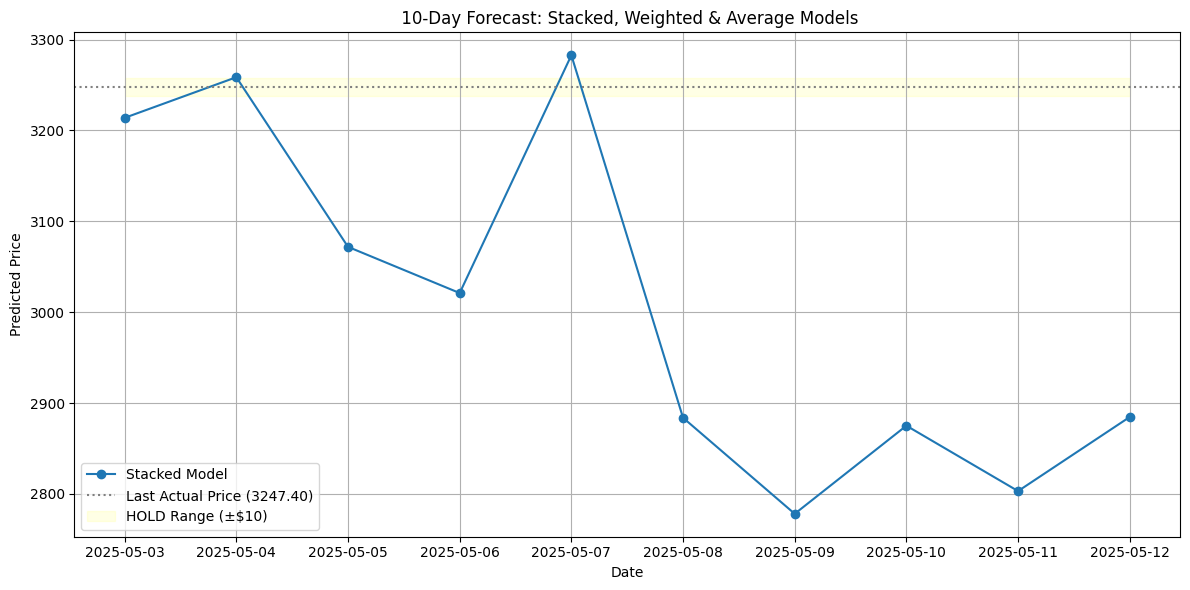

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Settings ===
n =10  # Number of future predictions (default: 5 days)2
threshold = 10  # Decision threshold for recommendation

# === Prepare Future Predictions ===
future_best1_values = np.array(best1_forecast_trimmed[-n:]).reshape(-1, 1)
future_best2_values = np.array(best2_forecast_trimmed[-n:]).reshape(-1, 1)

X_combined_future = np.column_stack([future_best1_values, future_best2_values])
scaler_minmax.fit(X_combined)  # Fit on previous features
X_combined_future_scaled = scaler_minmax.transform(X_combined_future)

# Stacked prediction
hybrid_predictions_future = meta_model.predict(X_combined_future_scaled).flatten()
# Weighted prediction
hybrid_weighted_future = (weight_best1 * future_best1_values.flatten()) + (weight_best2 * future_best2_values.flatten())
# Average prediction
hybrid_average_future = (future_best1_values.flatten() + future_best2_values.flatten()) / 2

# === Create Forecast DataFrame ===
future_dates = pd.date_range(start=y_test.index[-1], periods=n + 1, freq='D')[1:]
future_price = pd.DataFrame({
    'Future Price_stacked': hybrid_predictions_future,
}, index=future_dates)

# === Recommendation Logic ===
last_actual_price = y_test.values[-1]
recommendations = []
for forecast in hybrid_predictions_future:
    diff = forecast - last_actual_price
    if diff > threshold:
        recommendations.append("BUY 📈")
    elif diff < -threshold:
        recommendations.append("SELL 📉")
    else:
        recommendations.append("HOLD ⚖️")
future_price['Recommendation'] = recommendations

# === Trend & Signal Logic (Bonus) ===
trend = []
for i in range(len(hybrid_predictions_future)):
    if i >= 2:
        trend_window = hybrid_predictions_future[i-2:i+1]
        if np.all(np.diff(trend_window) > 0):
            trend.append("↗️ Uptrend Detected")
        elif np.all(np.diff(trend_window) < 0):
            trend.append("↘️ Downtrend Detected")
        else:
            trend.append("")
    else:
        trend.append("")
future_price['Signal'] = trend

# === Display Summary ===
print(f"Last Actual Observed Price: {last_actual_price:.2f}\n")
print(" Predicted Future Prices and Strategy:\n")
print(future_price)

# === Plot Forecasts ===
plt.figure(figsize=(12, 6))
plt.plot(future_price.index, future_price['Future Price_stacked'], label='Stacked Model', marker='o')

plt.axhline(last_actual_price, color='gray', linestyle=':', label=f'Last Actual Price ({last_actual_price:.2f})')
plt.fill_between(future_price.index, last_actual_price + threshold, last_actual_price - threshold,
                 color='yellow', alpha=0.1, label='HOLD Range (±$10)')
plt.title(" 10-Day Forecast: Stacked, Weighted & Average Models")
plt.xlabel("Date")
plt.ylabel("Predicted Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Predicting only with Real Time Data

In [105]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
n = days 
# Define scalers
scaler_minmax = MinMaxScaler()  # For XGBoost, Random Forest
scaler_standard = StandardScaler()  # For LSTM

# Apply MinMax Scaling (for tree-based models)
X_train_scaled_minmax = scaler_minmax.fit_transform(X_train)
X_test_scaled_minmax = scaler_minmax.transform(X_test)

# Apply Standard Scaling (for LSTM)
X_train_scaled_standard = scaler_standard.fit_transform(X_train)
X_test_scaled_standard = scaler_standard.transform(X_test)

# Select features and target
commodity_data_df = commodity_data_df.drop(columns=[ 'Close' ])
live_X_train = commodity_data_df[-n:]

# Apply existing scalers (already fitted during training)
X_live_scaled_minmax = scaler_minmax.transform(live_X_train)
X_live_scaled_standard = scaler_standard.transform(live_X_train)  # If needed for LSTM

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))


In [106]:
import joblib
import pickle
import os
import pandas as pd
import numpy as np

# Define the model directory
model_dir = hybrid_models_dir.get(commodity.upper())

# Define the model directory
meta_dir = hybrid_meta_models_dir.get(commodity.upper())
hybridmodel_name = 'meta_model_'+commodity+'.pkl'
hybrid_meta_model_name = os.path.join(meta_dir, hybridmodel_name)
# Load the meta-model (used in stacked hybrid)
with open(hybrid_meta_model_name, 'rb') as f:
    meta_model = pickle.load(f)

# Function to load models
def load_saved_models(directory):
    model_files = [f for f in os.listdir(directory) if f.endswith('.pkl')]
    models = {}
    for file in model_files:
        model_path = os.path.join(directory, file)
        model_name = file.replace(".pkl", "")
        model = joblib.load(model_path)
        models[model_name] = model
    return models

# Load all saved models
loaded_models = load_saved_models(model_dir)


def predict_from_model(model_name, model):
    if "XGBOOST" in model_name.upper():
        # Use model directly without re-fitting
        xgb_predictions = model.predict(X_live_scaled_minmax)
        
        # Inverse transform predictions back to original scale
        xgb_prediction = scaler_y.inverse_transform(xgb_predictions.reshape(-1, 1)).ravel()
        return xgb_prediction

    elif "ARIMA" in model_name.upper(): 
        # Prepare exogenous variables from live data (same order as during training)
        exog_live = X_live_scaled_minmax[:, [X_train.columns.get_loc(col) for col in X_train.columns]]
        # Use pretrained ARIMA model to forecast
        steps = len(exog_live)
        model2 = model.get_forecast(steps=steps, exog=exog_live)
        fc_model2 = model2.predicted_mean
        
        return fc_model2.values

        print(f"Unknown model type for {model_name}. Skipping.")
        return None

predict_l= {}
for model_name, model in loaded_models.items():
    print(f"\nPredicting using model: {model_name}")
    prediction = predict_from_model(model_name, model)
    predict_l[model_name]=prediction
    if prediction is not None:
        print("Predicted values:", prediction)



Predicting using model: ARIMA_best-1
Predicted values: [2302.94930878 2302.94930878 2302.94930878 2302.94930878 2302.94930878
 2302.94930878 2302.94930878 2302.94930878 2302.94930878 2293.54416553
 2308.51318937 2317.85020049 2318.12154078 2300.79687377 2306.60533116
 2308.62137177 2314.19812627 2307.04210763 2317.39532805 2303.25041891
 2311.91330566 2293.9413601  2306.31648438 2322.6102052  2269.83128033
 2291.84773018 2307.80609476 2296.0845846  2309.34830931 2309.68133582]

Predicting using model: XGBoost_best-2
Predicted values: [3413.824  3413.824  3413.824  3413.824  3413.824  3413.824  3413.824
 3413.824  3413.824  3412.9905 3407.5015 3410.0159 3415.4744 3421.2698
 3418.3352 3418.6108 3419.184  3424.1436 3422.3896 3427.3467 3424.9004
 3425.2957 3415.6304 3414.7222 3424.563  3401.7693 3397.4133 3400.4695
 3397.717  3402.8474]


C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [107]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Get individual model forecasts
best1_forecast_trimmed, best2_forecast_trimmed = list(predict_l.values())

# Ensure both forecasts are the same length
min_length = min(len(best1_forecast_trimmed), len(best2_forecast_trimmed))

best1_forecast_trimmed = best1_forecast_trimmed[:min_length]
best2_forecast_trimmed = best2_forecast_trimmed[:min_length]

# Now combine
X_combined = np.column_stack((best1_forecast_trimmed, best2_forecast_trimmed))

# Normalize features
X_combined_scaled = scaler_minmax.fit_transform(X_combined)

# Predict using stacked model
hybrid_predictions_stacked = meta_model.predict(X_combined_scaled)


In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

n = 24  # Number of future predictions
threshold = 3  # Decision threshold for recommendation

# === Prepare Future Predictions ===
future_best1_values = np.array(best1_forecast_trimmed[-n:]).reshape(-1, 1)
future_best2_values = np.array(best2_forecast_trimmed[-n:]).reshape(-1, 1)

X_combined_future = np.column_stack([future_best1_values, future_best2_values])
scaler_minmax.fit(X_combined)  # Fit on previous features
X_combined_future_scaled = scaler_minmax.transform(X_combined_future)

# Stacked prediction
hybrid_predictions_future = meta_model.predict(X_combined_future_scaled).flatten()
# Weighted prediction
hybrid_weighted_future = (weight_best1 * future_best1_values.flatten()) + (weight_best2 * future_best2_values.flatten())
# Average prediction
hybrid_average_future = (future_best1_values.flatten() + future_best2_values.flatten()) / 2

# === Create Forecast DataFrame ===
# Ensure future dates are hourly starting from the last actual date in y_test
last_actual_date = y_test.index[-1]  # Get the last date from y_test
future_dates = pd.date_range(start=last_actual_date, periods=n, freq='H')  # Hourly frequency
future_price = pd.DataFrame({
    'Future Price_stacked': hybrid_predictions_future,
}, index=future_dates)

# === Recommendation Logic ===
last_actual_price = y_test.values[-1]
recommendations = []
for forecast in hybrid_predictions_future:
    diff = forecast - last_actual_price
    if diff > threshold:
        recommendations.append("BUY")
    elif diff < -threshold:
        recommendations.append("SELL")
    else:
        recommendations.append("HOLD")
future_price['Recommendation'] = recommendations

# === Trend & Signal Logic (Bonus) ===
trend = []
for i in range(len(hybrid_predictions_future)):
    if i >= 2:
        trend_window = hybrid_predictions_future[i-2:i+1]
        if np.all(np.diff(trend_window) > 0):
            trend.append("↗️ Uptrend Detected")
        elif np.all(np.diff(trend_window) < 0):
            trend.append("↘️ Downtrend Detected")
        else:
            trend.append("")
    else:
        trend.append("")
future_price['Signal'] = trend



future_price

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3972\3798036492.py:26: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(start=last_actual_date, periods=n, freq='H')  # Hourly frequency


,Future Price_stacked,Recommendation,Signal
2025-05-02 00:00:00,3031.309412,SELL,
2025-05-02 01:00:00,3031.309412,SELL,
2025-05-02 02:00:00,3031.309412,SELL,
2025-05-02 03:00:00,3000.446177,SELL,
2025-05-02 04:00:00,2861.870886,SELL,↘️ Downtrend Detected
2025-05-02 05:00:00,2938.967866,SELL,
2025-05-02 06:00:00,3089.519234,SELL,↗️ Uptrend Detected
2025-05-02 07:00:00,3234.551474,SELL,↗️ Uptrend Detected
2025-05-02 08:00:00,3158.620121,SELL,
2025-05-02 09:00:00,3167.906316,SELL,


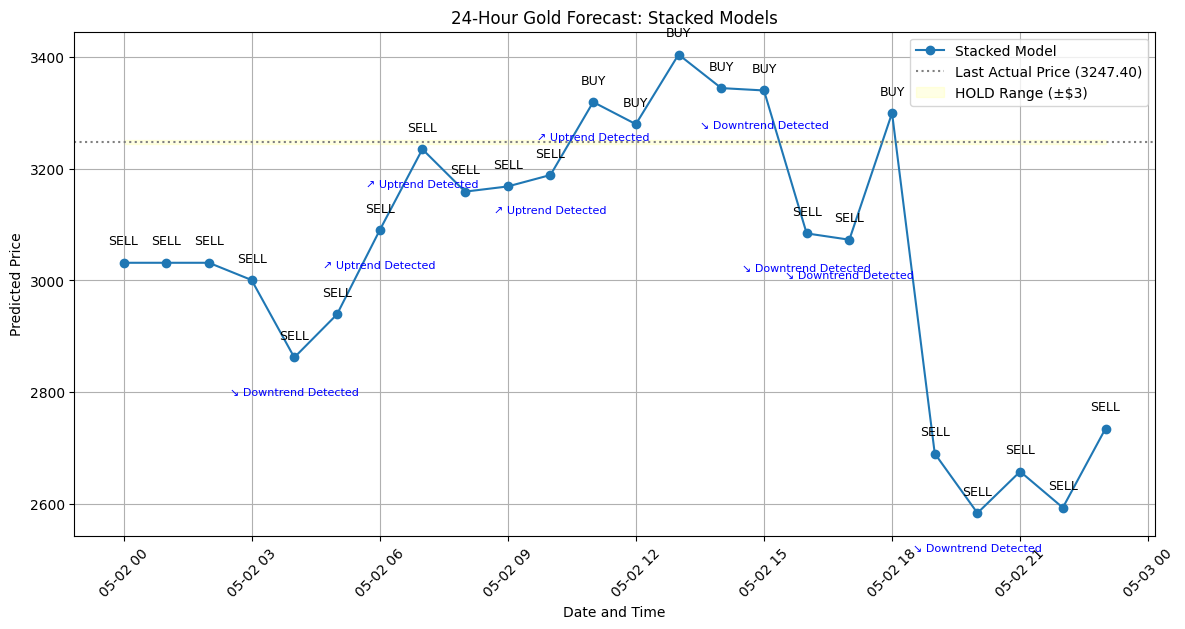

In [127]:
plt.figure(figsize=(12, 6))
plt.plot(future_price.index, future_price['Future Price_stacked'], label='Stacked Model', marker='o')

plt.axhline(last_actual_price, color='gray', linestyle=':', label=f'Last Actual Price ({last_actual_price:.2f})')
plt.fill_between(future_price.index, last_actual_price + threshold, last_actual_price - threshold,
                 color='yellow', alpha=0.1, label='HOLD Range (±$3)')
plt.title(f"{n}-Hour Gold Forecast: Stacked Models")
plt.xlabel("Date and Time")
plt.ylabel("Predicted Price")
plt.legend()
plt.grid(True)
plt.tight_layout()

# === Add Annotations with Boundary-Aware Positioning ===
ymin, ymax = plt.ylim()
text_offset = (ymax - ymin) * 0.03  # dynamic offset ~3% of range

for x, y, rec, sig in zip(future_price.index, 
                          future_price['Future Price_stacked'], 
                          future_price['Recommendation'], 
                          future_price['Signal']):
    # Calculate safe y-position for text (avoid going above ymax)
    y_text = y + text_offset
    if y_text > ymax:
        y_text = y - text_offset * 2  # put below if too high

    plt.text(x, y_text, rec, fontsize=9, ha='center', va='bottom')

    # Optional: show signal trend below the point
    if sig:
        plt.text(x, y - text_offset * 2, sig, fontsize=8, ha='center', va='top', color='blue')

# Optional: Rotate x-axis labels
plt.xticks(rotation=45)

plt.show()


In [121]:
# === Display Summary ===
print(f"Last Actual Observed Price: {last_actual_price:.2f}\n")
print("Predicted Future Prices and Strategy:\n")
future_price

Last Actual Observed Price: 3247.40

Predicted Future Prices and Strategy:



,Future Price_stacked,Recommendation,Signal
2025-05-02 00:00:00,3031.309412,SELL 📉,
2025-05-02 01:00:00,3031.309412,SELL 📉,
2025-05-02 02:00:00,3031.309412,SELL 📉,
2025-05-02 03:00:00,3000.446177,SELL 📉,
2025-05-02 04:00:00,2861.870886,SELL 📉,↘️ Downtrend Detected
2025-05-02 05:00:00,2938.967866,SELL 📉,
2025-05-02 06:00:00,3089.519234,SELL 📉,↗️ Uptrend Detected
2025-05-02 07:00:00,3234.551474,SELL 📉,↗️ Uptrend Detected
2025-05-02 08:00:00,3158.620121,SELL 📉,
2025-05-02 09:00:00,3167.906316,SELL 📉,
